# 원티드 3차 과제 - EDA
## 목데이터 특성 파악을 중심으로

- 차트를 만드는 목적은 데이터를 통해 인사이트를 쉽게 도출하기 위함입니다.
- 웹 시계열 차트를 만드는 과제를 수행하기 전 데이터를 파악하고 적합한 차트를 그리기 위해 EDA를 진행했습니다.
- 과제 데이터의 경우 메타데이터가 없으므로 기본적인 특성만을 분석하고자 합니다.

## 0. Setting

In [210]:
import warnings
warnings.filterwarnings(action='ignore')
import json, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

with open("public/mock/mockdata.json", encoding='utf-8') as f:
    js = json.loads(f.read())

df = pd.DataFrame(js['response']).T
df.head()

,id,value_area,value_bar
2023-02-01 14:32:00,성북구,46,13111
2023-02-01 14:32:05,강남구,9,19143
2023-02-01 14:32:10,노원구,79,14798
2023-02-01 14:32:15,중랑구,4,14456
2023-02-01 14:32:20,노원구,97,19116


- 데이터는 지역을 나타내는 컬럼(범주형) + 두가지 시계열 컬럼(수치형)으로 이루어져 있습니다.
- 시계열 데이터의 경우 추세, 계절성, 안정성 세가지 요소의 파악이 중요합니다. 
- 만약에 시계열이 안정적이지 않다면 현재의 패턴이 미래에 똑같이 재현되지 않기때문에, 그대로 예측기법 등의 적용이 힘듭니다.

## 1. 시각화

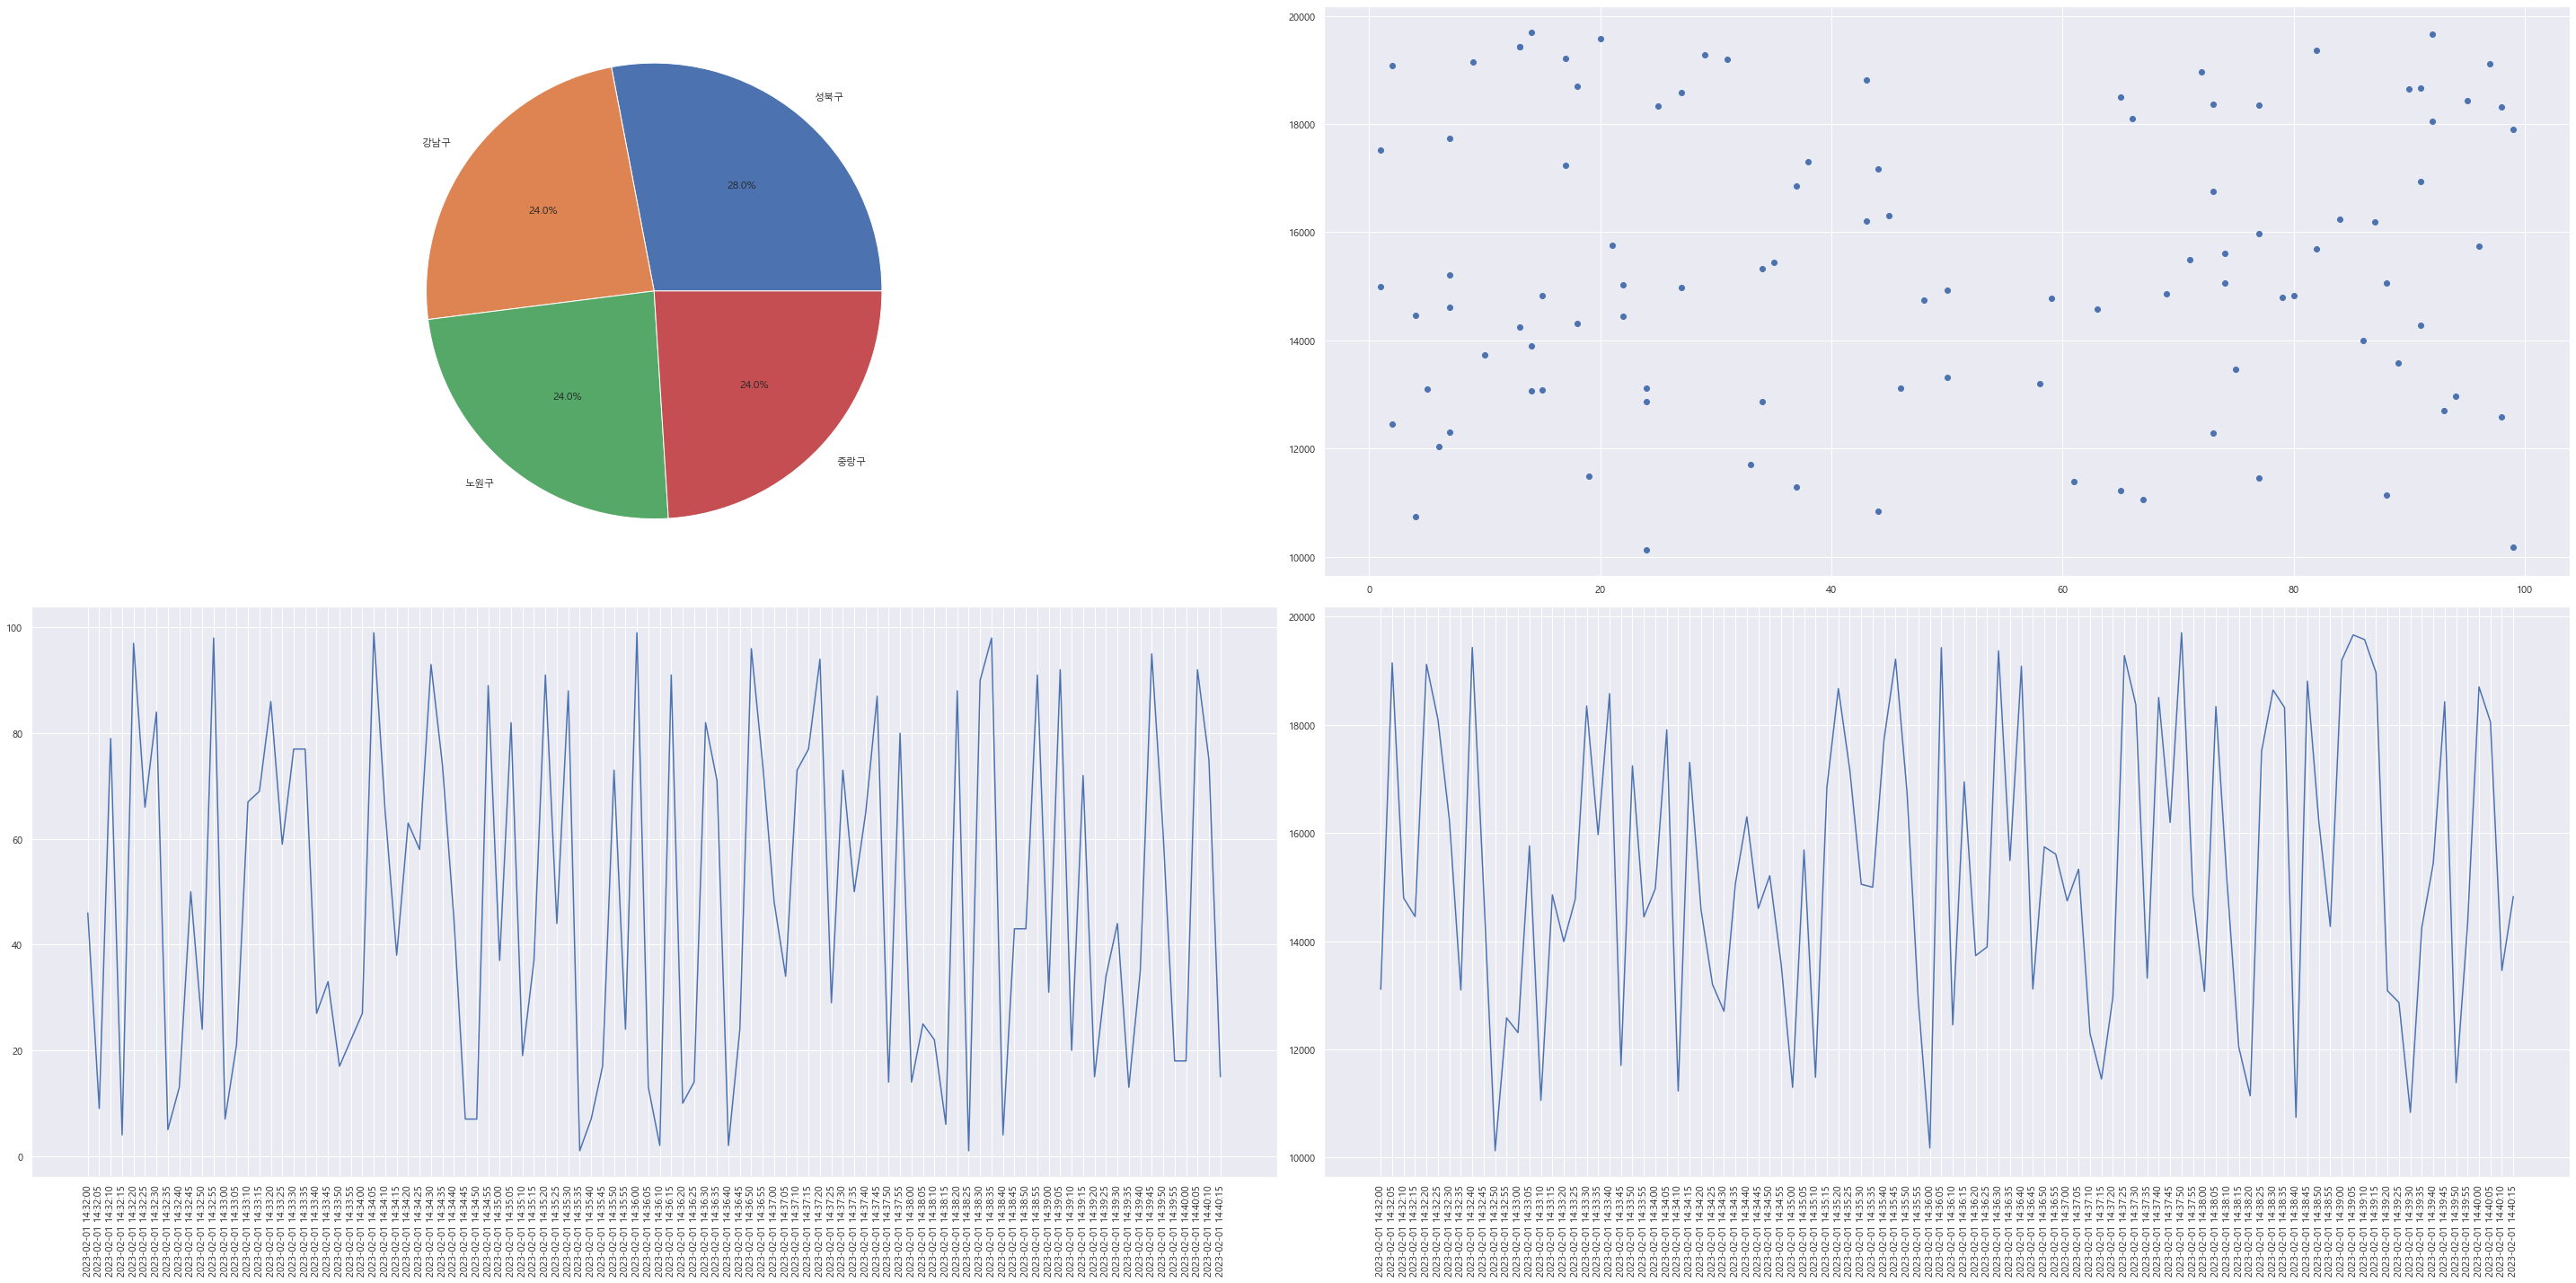

In [209]:
plt.figure(figsize=(40, 20))

plt.subplot(2, 2, 1)
plt.pie(df['id'].value_counts(), labels=df['id'].value_counts().index, autopct='%.1f%%')

plt.subplot(2, 2, 2)
plt.scatter(df['value_area'], df['value_bar'])

plt.subplot(2, 2, 3)
plt.plot(df['value_area'])
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
plt.plot(df['value_bar'])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

- 범주형 데이터 `id`의 경우, 성북구가  28%로 조금 더 많고 그 외는 동일하게 분포되어 있습니다.
- `value_area`와 `value_bar`는 특별한 관계를 가지지 않습니다.
- 시계열 데이터의 경우, 추세나 계절성이 없습니다. 그러므로 안정적으로 판단됩니다.

## 2. 시계열 분석
ADF 테스트와 KPSS 테스트를 모두 사용하여 시계열의 안정성에 대해 교차 확인할 것입니다.

### 2.1. ADF 안정성 테스트
ADF 테스트는 시계열이 안정적(Stationary)인지 여부를 확인하는데 이용되는 방법입니다.

- Null hypothesis: 기각에 실패하면 시계열이 안정적이지 않음을 의미합니다.
- Alternative hypothesis: 귀무 가설(null hypothesis)이 기각되고 시계열이 안정적임을 의미합니다.

In [108]:
def adf_test(values):
    result = adfuller(values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
print('ADF Test: value_area')
adf_test(df['value_area'])
print('\nADF Test: value_bar')
adf_test(df['value_bar'])

ADF Test: value_area
ADF Statistics: -11.450498
p-value: 0.000000
Critical values:
	1%: -3.498
	5%: -2.891
	10%: -2.583

ADF Test: value_bar
ADF Statistics: -5.163666
p-value: 0.000010
Critical values:
	1%: -3.502
	5%: -2.893
	10%: -2.583


- p-value < 0.05 이므로 귀무 가설을 기각 합니다. 따라서 두 개의 시계열은 안정적입니다.

### 2.2. KPSS 안정성 테스트
시계열이 평균 또는 선형 추세 주변에 고정되어 있는지 또는 단위 루트(unit root)로 인해 고정되지 않은지 확인합니다.

- Null hypothesis: 시계열이 안정적입니다.
- Alternative hypothesis: 시계열이 안정적이지 않습니다.

In [159]:
def kpss_test(values):    
    statistic, p_value, n_lags, critical_values = kpss(values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

print('KPSS  Test: value_area')
kpss_test(df['value_area'])
print('\nKPSS  Test: value_bar')
kpss_test(df['value_bar'])

KPSS  Test: value_area
KPSS Statistic: 0.06021346300418588
p-value: 0.1
num lags: 12
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739

KPSS  Test: value_bar
KPSS Statistic: 0.22758849425522884
p-value: 0.1
num lags: 12
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


- p-value > 0.05 이므로 귀무 가설을 기각 할 수 없습니다. 두 개의 시계열은 안정적임을 알 수 있습니다.
- 앞선 시각화와 교차 확인 결과를 통해 시계열 데이터 모두 안정적이라는 결론을 내릴 수 있습니다.

### 2.3. 지역별 안정성 테스트
현재 데이터는 여러 지역이 섞여 있습니다. 각 지역별로 구분하여도 안정적인지 확인합니다.

In [161]:
def adf_test_only_p_value(values):
    result = adfuller(values)
    print('ADF p-value: %f' % result[1])
        
def kpss_test_only_p_value(values):    
    statistic, p_value, n_lags, critical_values = kpss(values)
    print(f'KPSS p-value: {p_value}')

for loc in df['id'].value_counts().index:
    df_by_loc = df[df['id'] == loc]
    print(f'\n{loc} Test:')
    adf_test_only_p_value(df_by_loc['value_area'])
    kpss_test_only_p_value(df_by_loc['value_area'])


성북구 Test:
ADF p-value: 0.007769
KPSS p-value: 0.1

강남구 Test:
ADF p-value: 0.065291
KPSS p-value: 0.1

노원구 Test:
ADF p-value: 0.000026
KPSS p-value: 0.09626532001173367

중랑구 Test:
ADF p-value: 0.000000
KPSS p-value: 0.08952778863900929


- 강남구의 ADF 테스트 결과를 제외하고는 유의 수준 0.05에서 같은 추론을 할 수 있습니다.
- 즉 지역별로 구분하여도 안정성을 가진다고 판단됩니다.

## 3. 결론

분석을 통해 파악한 특성은 아래와 같습니다.

- 범주형 데이터 `id`의 경우, 성북구가  28%로 조금 더 많고 그 외는 동일하게 분포되어 있습니다.
- `value_area`와 `value_bar`는 **특별한 관계를 가지지 않습니다.**
- 시계열 데이터는 추세와 계절성 없이 모두 **안정적**이라는 추론이 가능합니다. 그러므로 추가적인 처리 없이 시계열 모델링이 가능합니다. 

---

#### 용어
- [추세, Trend]: 장기적으로 증가하거나, 감소하는 경향성이 존재하는 것
- [계절성, Seasonality]: 계절적 요인의 영향을 받아 1년, 혹은 일정 기간 안에 반복적으로 나타나는 패턴
- [안정성, 정상성, Stationary]: 시간에 상관없이 일정한 성질을 띠고 있는 것

#### Reference

- [모두의 연구소: 시계열 정상성 (Stationarity), 들어봤니? – 알아보자 시계열 분석 Episode 2](https://modulabs.co.kr/blog/time-series-stationarity)



_※ 이 문서는 Jupyter Notebook으로 작성 후 Markdown 파일로 변환하였습니다._
